In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn as nn
from torch.utils.data import WeightedRandomSampler
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from eeg_dataset_utils import EEGDatasetAdvanced, my_train_test_split
from offline_bci import OfflineBCI, split_by_words

In [3]:
from IPython.display import clear_output

## Сверточная сеть

In [4]:
class ConvEEGNN2(nn.Module):

    def __init__(self, n_eeg_channels=44, kernel_size=10):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(n_eeg_channels, 16, kernel_size=kernel_size),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=kernel_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.fc = nn.Linear(in_features=8, out_features=1)

    def forward(self, batch):
        out = self.cnn_layers(batch)
        out = self.fc(out)
        return torch.sigmoid(out)



In [5]:
import lightning.pytorch as pl
from torch import optim
import torchmetrics
from lightning.pytorch.loggers import TensorBoardLogger

class LitCNN(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.fb = torchmetrics.classification.BinaryFBetaScore(beta=0.5)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.model(x)
        loss = nn.functional.binary_cross_entropy(out.squeeze(1), y)

        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def on_validation_epoch_end(self):
        fb = self.fb.compute()
        self.log("fbeta", self.fb.compute())
        print("Fbeta =", fb)
        self.fb.reset()
        acc = self.accuracy.compute()
        self.log("accuracy", self.accuracy.compute())
        # print("Accuracy =", acc)
        self.accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.fb.update(out.squeeze(1), y)
        self.accuracy.update(out.squeeze(1), y)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

# Build the dataset

In [6]:
rd = 'd:\\Study\\MSUAI\\P300BCI_ordered_DataSet'

In [7]:
from eeg_dataset_utils import EEGDatasetAdvanced, my_train_test_split

class DatasetBuilder():
  def __init__(self, path = '/content/', subjects = ['ik'], channels = ['Pz'],
               n_average=None, discret=35, reverse_labels=False):
    cache_dir_name = f'eeg_cache_{discret}Hz'
    self.dataset = EEGDatasetAdvanced(path,
                             subjects = subjects,
                             load_cache=True,
                             cache_dir_name=cache_dir_name,
                             n_average=n_average,
                             discret=discret,
                             reverse_labels=reverse_labels)
    self.dataset.pick_channels(channels)
    # self.check()

  def check(self):
    # Cheking for file errors
    for i in range(len(self.dataset)):
      try:
        x = self.dataset[i]
      except Exception as e:
        print(e,i,self.dataset.data[i])

  def calculate_mean_and_std(self):
    loader = DataLoader(self.dataset, batch_size=len(self.dataset), shuffle=False)
    data, labels = next(iter(loader))
    return data.mean(dim=(0,2)) , data.std(dim=(0,2))

  def __call__(self):
    mean, std = self.calculate_mean_and_std()
    self.dataset.transform = lambda x: (x - mean[:,None]) / std[:,None]
    return self.dataset

Create dataset

In [16]:
from torch.utils.data import WeightedRandomSampler

#dataset.pick_channels(['Pz'])
# dataset.pick_subjects(dataset.available_subjects[:5])

builder = DatasetBuilder(rd, channels = ch_set[8], subjects=['ik'])
dataset = builder()

print("Available_subjects: ", *dataset.available_subjects)
print('Dataset length:',len(dataset), "Item shape", dataset[0][0].shape)

# train_set, test_set = my_train_test_split(dataset, [.8, .2], control_subject=False)
# print('Training length:',len(train_set))

# # Add sampler
# labels = torch.tensor([y.item() for _, y in train_set], dtype=torch.long)
# class_weights = [8,1]
# samples_weights = torch.zeros(len(train_set))
# samples_weights[labels==0] = class_weights[0]
# samples_weights[labels==1] = class_weights[1]

# sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# train_loader = DataLoader(train_set, batch_size=64, sampler=sampler)
# test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Available_subjects:  ak as az dad dkv ds dsi dzg eab en fks hra ieh ik irk kka kms lv mam mb mbm mbu mma mp nb nva rae rkv sav sdk ski smv ss tg tp
Dataset length: 3599 Item shape torch.Size([8, 21])


# Offline BCI, ITR

In [10]:
from offline_bci import split_by_words, OfflineBCI

In [22]:
train_set, test_set = split_by_words(dataset, 3)
print('train_size:', len(train_set))
print('test_size:', len(test_set))

train_size: 2699
test_size: 900


In [23]:
train_set.average(8)
print('train size:', len(train_set))

train size: 336


In [24]:
labels = torch.tensor([y.item() for _, y in train_set], dtype=torch.long)
class_weights = [8,1]
samples_weights = torch.zeros(len(train_set))
samples_weights[labels==0] = class_weights[0]
samples_weights[labels==1] = class_weights[1]

sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

train_loader = DataLoader(train_set, 64, sampler=sampler)
test_set.average(8)
test_loader = DataLoader(test_set, 64, shuffle=False)

C:\Users\Timot\AppData\Local\Temp\ipykernel_13740\563556354.py:1: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([y.item() for _, y in train_set], dtype=torch.long)


In [25]:
from lightning.pytorch.loggers import TensorBoardLogger

pl.seed_everything(42)
model = ConvEEGNN2(n_eeg_channels=8)
lit_model = LitCNN(model)
logger = TensorBoardLogger(save_dir=os.getcwd(), version="8ch", name="lightning_logs")
trainer = pl.Trainer(limit_train_batches=100, max_epochs=25, log_every_n_steps = 5, logger=logger)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders= test_loader)

clear_output()

In [ ]:
bci = OfflineBCI(test_set, model, model_type='NN')
bci.pipeline(8, summary=True)

In [48]:
dataset = EEGDatasetAdvanced('./P300BCI_ordered_DataSet/', cache_dir_name='eeg_cache_35Hz',
                             downsample=15, dtype=np.float16)

100%|██████████| 35/35 [05:33<00:00,  9.52s/it]


All data is cached in ./P300BCI_ordered_DataSet/eeg_cache_35Hz


In [61]:
# Instead tensorboard
from tbparse import SummaryReader

fname = 'Test_16ch_35Hz_8ep_lr2'
log_dir = "D:/Study/MSUAI/lightning_logs/" + fname
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

     step         tag     value
0       5    accuracy  0.625000
1      11    accuracy  0.741071
2      17    accuracy  0.830357
3      23    accuracy  0.892857
4      29    accuracy  0.928571
..    ...         ...       ...
535   579  train_loss  0.000249
536   584  train_loss  0.000051
537   589  train_loss  0.000104
538   594  train_loss  0.000058
539   599  train_loss  0.000076

[540 rows x 3 columns]


In [62]:
df.tag.unique()

array(['accuracy', 'epoch', 'fbeta', 'train_loss'], dtype=object)

In [63]:
# Prepare for plotting
metric = df[df.tag=='fbeta']
epoch = df[df.tag=='epoch']
loss = df[df.tag=='train_loss']
for d in [metric, epoch, loss]:
    name = d.tag.unique().item()
    d.drop(['tag'], axis=1, inplace=True)
    d.rename(columns={'value':name}, inplace=True)

clear_output()

In [64]:
df2 = metric.merge(loss, on='step').merge(epoch, on='step')
df2 = df2.melt(id_vars=['step', 'epoch']).drop_duplicates()
df2.head()

,step,epoch,variable,value
0,29,4.0,fbeta,0.673077
2,59,9.0,fbeta,0.795455
4,89,14.0,fbeta,0.795455
6,119,19.0,fbeta,0.750000
8,149,24.0,fbeta,0.750000


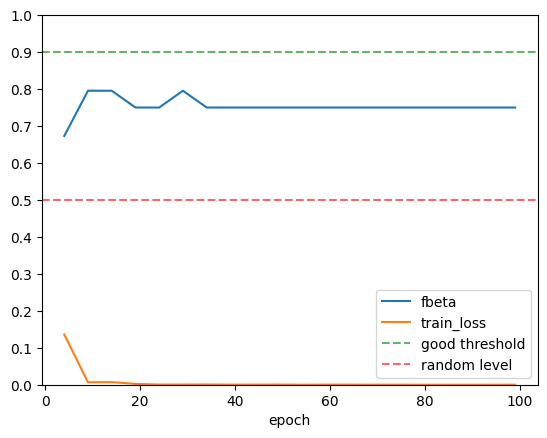

In [65]:
import seaborn as sns
fig, ax = plt.subplots(1)
sns.lineplot(df2, x='epoch', y='value', hue='variable', ax=ax)
ax.set(ylim=(0,1), yticks=np.arange(0,1.1,0.1), ylabel='')
ax.axhline(0.9, c='g', ls='--', alpha=0.6, label='good threshold')
ax.axhline(0.5, c='r', ls='--', alpha=0.6, label='random level')
ax.legend()

plt.show()

# Tests

In [8]:
rd = 'd:\\Study\\MSUAI\\P300BCI_ordered_DataSet'

In [9]:
ch_set = {
    1: ['Pz'],
    4: ['Pz', 'POz', 'Cz', 'Fz'],
    8: ['P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'Cz', 'Fz'],
    16: ['Fz', 'Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5',
         'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']
}

In [10]:
from itertools import product
grid = list(product((1, 4, 8, 16), (1, 2, 4, 6, 8)))

In [29]:
dataset = EEGDatasetAdvanced(rd, subjects=['ik'], cache_dir_name='eeg_cache_35Hz')
subjects = dataset.available_subjects

In [33]:
from pprint import pprint
pprint(subjects, compact=True)

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
 'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
 'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']


In [15]:
subjects = subjects[:8] + ['tp', 'ik'] # First 8 subjects plus Me and my friend :) 

In [16]:
subjects

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'tp', 'ik']

In [17]:
from torchmetrics.classification import BinaryConfusionMatrix, BinaryAccuracy, BinaryF1Score, BinaryFBetaScore, BinaryPrecision, BinaryRecall
from copy import deepcopy


pl.seed_everything(42)

# Factors
channels = 8
discret = 35
average = 8
subject = 'ik'
lr = 1e-3
kernel_size = 10

result = []
n=1

for subject in subjects:
# for channels, average in grid:
    # discret = 35
    print(f'Run {n}/10: {subject} {discret}Hz, {channels}ch, {average}ep')
    n+=1
    # Create dataset
    builder = DatasetBuilder(rd, channels=ch_set[channels], subjects=[subject], discret=discret, reverse_labels=True)
    dataset = builder()
    train_set, test_set = split_by_words(dataset, 3)

    test_set_no_average = deepcopy(test_set)
    train_set.average(average)
    test_set.average(average)

    # Sampling, dataloader
    labels = torch.tensor([y.item() for _, y in train_set], dtype=torch.long)
    class_weights = [1,8] # NOTE: Indx must strictly match class numbers
    samples_weights = torch.zeros(len(train_set))
    samples_weights[labels==0] = class_weights[0]
    samples_weights[labels==1] = class_weights[1]
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

    train_loader = DataLoader(train_set, 64, sampler=sampler)
    test_loader = DataLoader(test_set, 64, shuffle=False)

    # Train model
    model = ConvEEGNN2(n_eeg_channels=channels, kernel_size=kernel_size)
    lit_model = LitCNN(model, lr)
    logger = TensorBoardLogger(save_dir=os.getcwd(), version=f'Test_{subject}_{channels}ch_{discret}Hz_{average}ep', name="lightning_logs")
    trainer = pl.Trainer(limit_train_batches=100, max_epochs=100, log_every_n_steps = 5, logger=logger)
    trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

    clear_output()

    loader = DataLoader(test_set, batch_size=len(train_set), shuffle=False)
    X, y = next(iter(loader))
    model.eval()
    out = model(X).squeeze(1)

    accuracy = BinaryAccuracy()
    acc = accuracy(out, y)
    f1score = BinaryF1Score()
    f1 = f1score(out, y)
    fbscore = BinaryFBetaScore(beta=0.5)
    fbeta = fbscore(out, y)
    precision = BinaryPrecision()
    prec = precision(out, y)
    recall = BinaryRecall()
    rec = recall(out, y)

    cm = BinaryConfusionMatrix(threshold=0.5)
    cm.update(out, y)
    tn, fp, fn, tp = cm.compute().ravel()

    bci = OfflineBCI(test_set_no_average, model, model_type='NN')
    itr, bci_acc = bci.pipeline(average)

    balanced_accuracy = ((tp/(tp+fp))+(tn/(tn+fn)))/2
    
    res = {
        'subject': subject,
        'channels': channels,
        'discretization': discret,
        'average': average,
        'accuracy': acc.item(),
        'balanced_accuracy': balanced_accuracy.item(),
        'f1': f1.item(),
        'fbeta': fbeta.item(),
        'precision': prec.item(),
        'recall': rec.item(),
        'bci_accuracy': bci_acc,
        'itr': itr,
        'tp': tp.item(),
        'tn': tn.item(),
        'fp': fp.item(),
        'fn': fn.item()
    }

    result.append(res)
    if n%5==0:
        df = pd.DataFrame(result)
        df.to_csv(f'NN_test_3_log_{n}.csv')